In [147]:
# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [148]:
# Load dataset
data = pd.read_csv("../data/01_clean_data.csv")

In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16048 entries, 0 to 16047
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   WEIGHT              16048 non-null  float64
 1   GENDER              16048 non-null  object 
 2   NUMBER_OF_CHILDREN  16048 non-null  float64
 3   AGE                 16048 non-null  float64
 4   HOUSEHOLD_SIZE      16048 non-null  float64
 5   TV_TOTAL            16048 non-null  float64
 6   FLYERS              16048 non-null  float64
 7   PRINT_TOTAL         16048 non-null  float64
 8   ONLINE_VIDEO        16048 non-null  float64
 9   ONLINE_DISPLAY      16048 non-null  float64
 10  ONLINE_TOTAL        16048 non-null  float64
 11  TIKTOK              16048 non-null  float64
 12  YOUTUBE_TOTAL       16048 non-null  float64
 13  YOUTUBE_MOBILE      16048 non-null  float64
 14  YOUTUBE_DESKTOP     16048 non-null  float64
 15  YOUTUBE_TABLET      16048 non-null  float64
 16  YOUT

## Outlier Detection

In [150]:
# Apply one-hot encoding
data = pd.get_dummies(data, columns=['GENDER'], drop_first=True)

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16048 entries, 0 to 16047
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   WEIGHT              16048 non-null  float64
 1   NUMBER_OF_CHILDREN  16048 non-null  float64
 2   AGE                 16048 non-null  float64
 3   HOUSEHOLD_SIZE      16048 non-null  float64
 4   TV_TOTAL            16048 non-null  float64
 5   FLYERS              16048 non-null  float64
 6   PRINT_TOTAL         16048 non-null  float64
 7   ONLINE_VIDEO        16048 non-null  float64
 8   ONLINE_DISPLAY      16048 non-null  float64
 9   ONLINE_TOTAL        16048 non-null  float64
 10  TIKTOK              16048 non-null  float64
 11  YOUTUBE_TOTAL       16048 non-null  float64
 12  YOUTUBE_MOBILE      16048 non-null  float64
 13  YOUTUBE_DESKTOP     16048 non-null  float64
 14  YOUTUBE_TABLET      16048 non-null  float64
 15  YOUTUBE_CTV         16048 non-null  float64
 16  PINT

In [152]:
from sklearn.ensemble import IsolationForest

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Set contamination to the expected outlier proportion
outliers = iso_forest.fit_predict(data)

# Attach results to df
data["outlier_score"] = iso_forest.decision_function(data)
data['outlier'] = outliers

# Check number of outliers
print((outliers == -1).sum())

803


[]

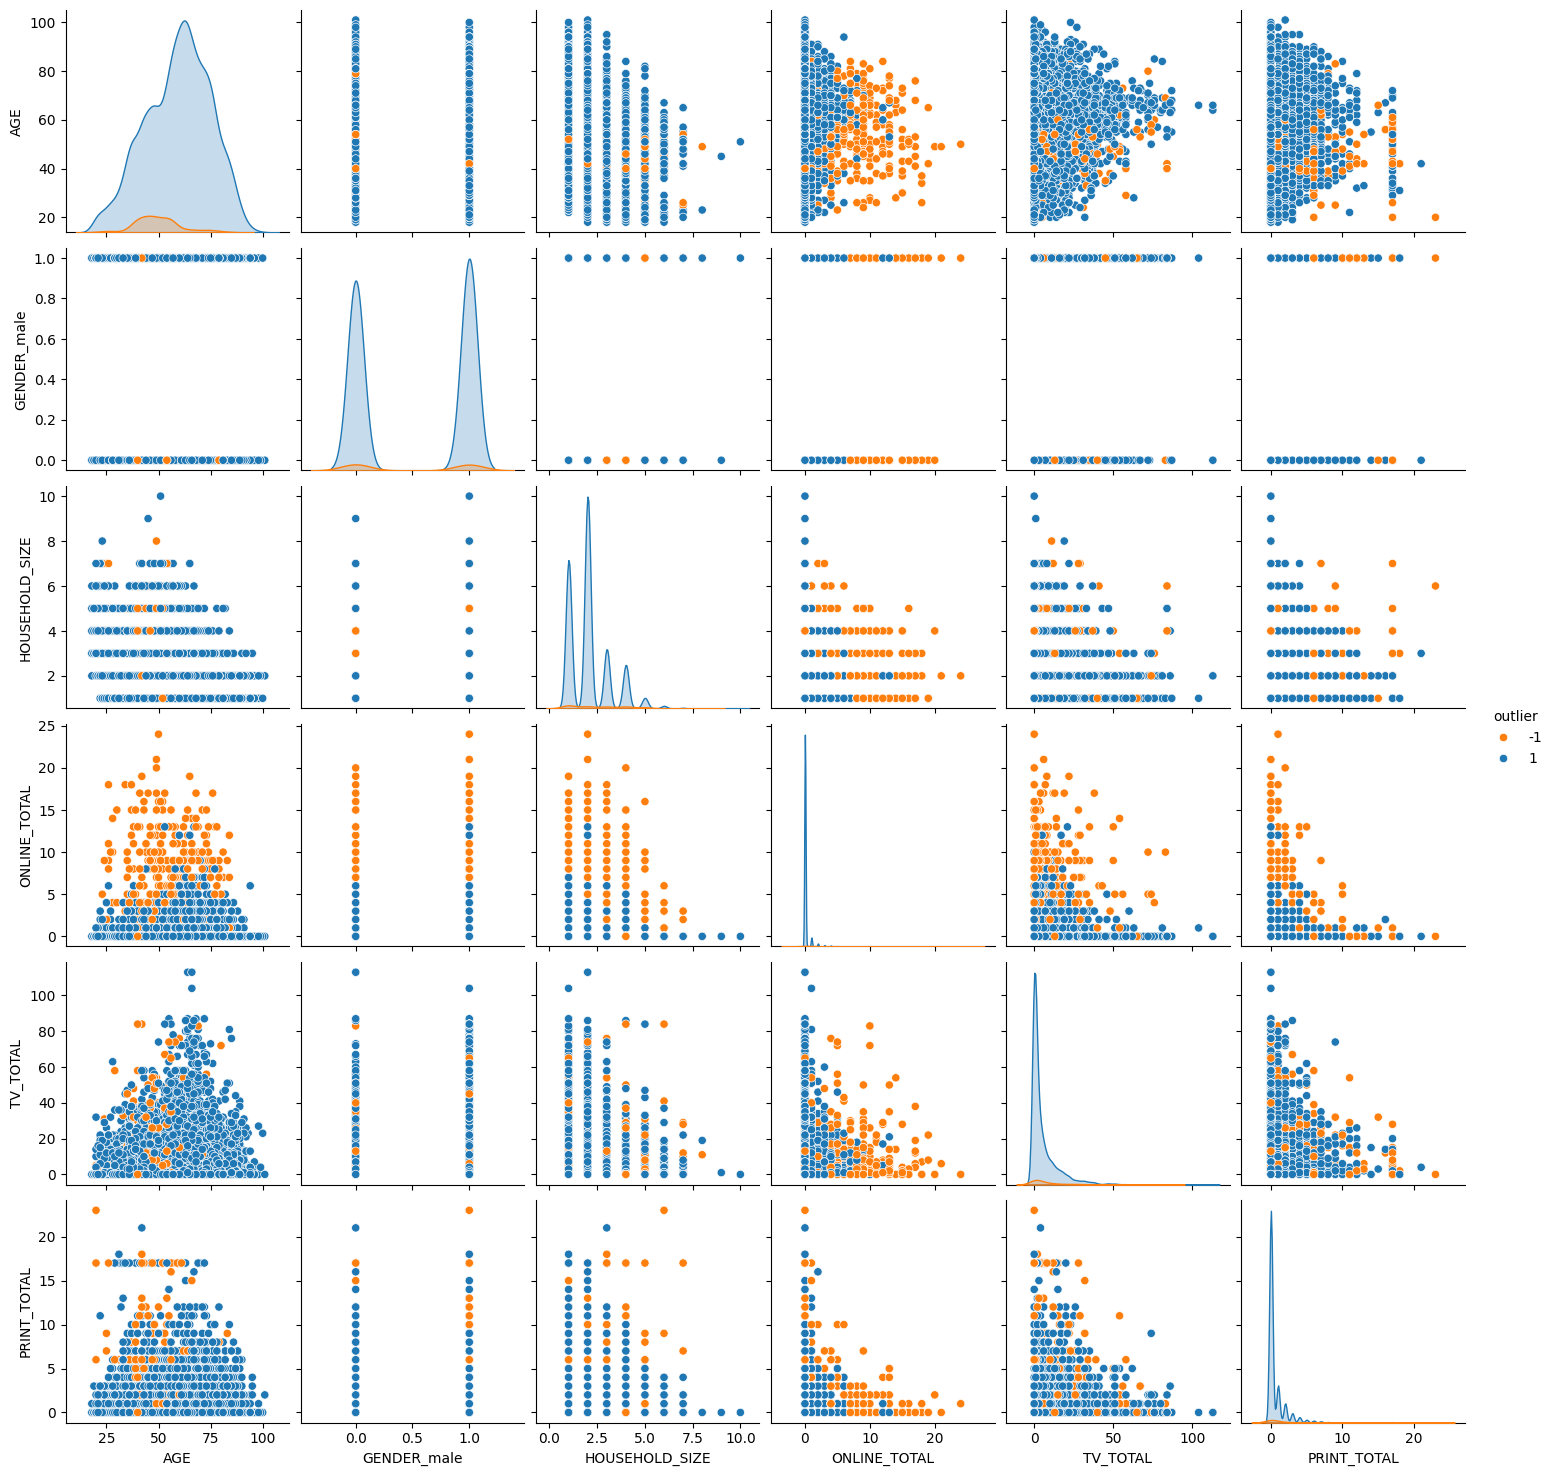

In [154]:
# Visualize Outliers
data_to_plot = data[["AGE", "GENDER_male", "HOUSEHOLD_SIZE", "ONLINE_TOTAL", "TV_TOTAL", "PRINT_TOTAL", "outlier"]]

palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(data_to_plot, vars=data_to_plot.drop(columns=["outlier"]), hue='outlier', palette=palette)
plt.plot()

### Drop Outliers

In [155]:
# -1 indicates an outlier, 1 indicates a normal point
# data['outlier'] = outliers
data = data[data['outlier'] == 1]
data.drop(columns=['outlier', 'outlier_score'], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15245 entries, 1 to 16047
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   WEIGHT              15245 non-null  float64
 1   NUMBER_OF_CHILDREN  15245 non-null  float64
 2   AGE                 15245 non-null  float64
 3   HOUSEHOLD_SIZE      15245 non-null  float64
 4   TV_TOTAL            15245 non-null  float64
 5   FLYERS              15245 non-null  float64
 6   PRINT_TOTAL         15245 non-null  float64
 7   ONLINE_VIDEO        15245 non-null  float64
 8   ONLINE_DISPLAY      15245 non-null  float64
 9   ONLINE_TOTAL        15245 non-null  float64
 10  TIKTOK              15245 non-null  float64
 11  YOUTUBE_TOTAL       15245 non-null  float64
 12  YOUTUBE_MOBILE      15245 non-null  float64
 13  YOUTUBE_DESKTOP     15245 non-null  float64
 14  YOUTUBE_TABLET      15245 non-null  float64
 15  YOUTUBE_CTV         15245 non-null  float64
 16  PINTEREST

## 2. Feature Engineering

### 2.1 Interaction Features

In [156]:
# Normalize media exposure by household size
# This helps analyze per-person media exposure in larger households
data["MEDIA_PER_HOUSEHOLD_MEMBER"] = data["TOTAL_MEDIA_EXPOSURE"] / data["HOUSEHOLD_SIZE"]

KeyError: 'TOTAL_MEDIA_EXPOSURE'

In [157]:
# Normalize media exposure per child, avoiding division by zero
# Assumes households without children still have at least 1 consumer
data["MEDIA_PER_CHILD"] = data["TOTAL_MEDIA_EXPOSURE"] / (data["NUMBER_OF_CHILDREN"] + 1)

KeyError: 'TOTAL_MEDIA_EXPOSURE'

### 2.2 Media-Specific Aggregations

## Total Media Exposure

In [158]:
# Total Media Exposure
media_channels = ['TV_TOTAL', 'PRINT_TOTAL', 'ONLINE_VIDEO', 'ONLINE_DISPLAY', 'YOUTUBE_TOTAL', 'TIKTOK']
data = data.copy()
data['TOTAL_MEDIA_EXPOSURE'] = data[media_channels].sum(axis=1)

In [159]:
# Aggregate different media types
# Digital media includes all online platforms
data["DIGITAL_MEDIA_TOTAL"] = data["ONLINE_TOTAL"] + data["YOUTUBE_TOTAL"] + data["TIKTOK"] + data["PINTEREST"]

In [160]:
# Traditional media groups TV, print, and flyers
data["TRADITIONAL_MEDIA_TOTAL"] = data["TV_TOTAL"] + data["PRINT_TOTAL"] + data["FLYERS"]

In [161]:
# Social media exposure (video-based and platform-based)
data["SOCIAL_MEDIA_TOTAL"] = data["YOUTUBE_TOTAL"] + data["TIKTOK"] + data["PINTEREST"]

In [162]:
# Video advertising impact across channels
data["VIDEO_MEDIA_TOTAL"] = data["ONLINE_VIDEO"] + data["YOUTUBE_TOTAL"] + data["TIKTOK"]

### 2.3 Purchase Behavior Indicators

### Age Group

Age Group would be quite useful for further research. I had to experiment with the buckets a bit. The data favors older people with younger account for a much smaller proportion of the observations which is why the first bucket is doubled. The dataset was collected from people 18 and up so no under 18 bucket.

In [163]:
# Creating Age Group
data['AGE_GROUP'] = pd.cut(data['AGE'], bins=[17, 34, 44, 54, 64, 74, 120], 
                           labels=['18-34', '35-44', '45-54', '55-64', '65-74', '75+'])

# Check the results
data["AGE_GROUP"].value_counts(dropna=False)

AGE_GROUP
55-64    3883
65-74    3338
75+      2615
45-54    2470
35-44    1952
18-34     987
Name: count, dtype: int64

In [164]:
# Identifying heavy media consumers
# If a user’s total media exposure is above the median, they are classified as heavy users
median_exposure = data["TOTAL_MEDIA_EXPOSURE"].median()
data["HEAVY_MEDIA_USER"] = (data["TOTAL_MEDIA_EXPOSURE"] > median_exposure).astype(int)

In [165]:
# Identifying users highly engaged with video content
median_video_exposure = data["VIDEO_MEDIA_TOTAL"].median()
data["ENGAGED_VIDEO_USER"] = (data["VIDEO_MEDIA_TOTAL"] > median_video_exposure).astype(int)

In [166]:
# Placeholder for defining a target group (adjust logic as needed)
# Example: Users who have high media exposure and belong to certain age groups
data["TARGET_GROUP"] = ((data["TOTAL_MEDIA_EXPOSURE"] > median_exposure) & (data["AGE_GROUP"].isin(["25-34", "35-44"])) ).astype(int)

In [167]:
# Display the first few rows to check new features
data.head()

,WEIGHT,NUMBER_OF_CHILDREN,AGE,HOUSEHOLD_SIZE,TV_TOTAL,FLYERS,PRINT_TOTAL,ONLINE_VIDEO,ONLINE_DISPLAY,ONLINE_TOTAL,...,GENDER_male,TOTAL_MEDIA_EXPOSURE,DIGITAL_MEDIA_TOTAL,TRADITIONAL_MEDIA_TOTAL,SOCIAL_MEDIA_TOTAL,VIDEO_MEDIA_TOTAL,AGE_GROUP,HEAVY_MEDIA_USER,ENGAGED_VIDEO_USER,TARGET_GROUP
1,2581.77,0.0,52.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,False,3.0,2.0,1.0,2.0,2.0,45-54,0,1,0
2,8219.48,1.0,38.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,...,True,5.0,1.0,4.0,1.0,1.0,35-44,1,1,1
5,13456.38,0.0,27.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,0.0,0.0,0.0,0.0,0.0,18-34,0,0,0
8,6353.90,0.0,91.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,True,1.0,0.0,1.0,0.0,0.0,75+,0,0,0
9,2966.01,0.0,69.0,2.0,81.0,3.0,1.0,0.0,0.0,0.0,...,True,82.0,0.0,85.0,0.0,0.0,65-74,1,0,0


### Save data with the added features

In [168]:
# Save DataFrame
directory = "..\data"
filename = "02_engineered_data.csv"

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Full file path
filepath = os.path.join(directory, filename)

data.to_csv(filepath, index=False)
print(f"✅ File '{filename}' successfully saved to '{directory}'")

✅ File '02_engineered_data.csv' successfully saved to '..\data'


In [ ]:
# # Saving dataset for future use
# os.chdir("..")
# from src.utils import save_dataframe

# save_dataframe(data, "02_engineered_data.csv")

✅ Data successfully saved to ../data\02_engineered_data.csv with separator ','
